In [92]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [93]:
# Load the data
df = pd.read_csv('dummy_data.csv') # src: https://www.kaggle.com/datasets/imyjoshua/average-time-spent-by-a-user-on-social-media
df.head()

,age,gender,time_spent,platform,interests,location,demographics,profession,income,indebt,isHomeOwner,Owns_Car
0,56,male,3,Instagram,Sports,United Kingdom,Urban,Software Engineer,19774,True,False,False
1,46,female,2,Facebook,Travel,United Kingdom,Urban,Student,10564,True,True,True
2,32,male,8,Instagram,Sports,Australia,Sub_Urban,Marketer Manager,13258,False,False,False
3,60,non-binary,5,Instagram,Travel,United Kingdom,Urban,Student,12500,False,True,False
4,25,male,1,Instagram,Lifestlye,Australia,Urban,Software Engineer,14566,False,True,True


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           1000 non-null   int64 
 1   gender        1000 non-null   object
 2   time_spent    1000 non-null   int64 
 3   platform      1000 non-null   object
 4   interests     1000 non-null   object
 5   location      1000 non-null   object
 6   demographics  1000 non-null   object
 7   profession    1000 non-null   object
 8   income        1000 non-null   int64 
 9   indebt        1000 non-null   bool  
 10  isHomeOwner   1000 non-null   bool  
 11  Owns_Car      1000 non-null   bool  
dtypes: bool(3), int64(3), object(6)
memory usage: 73.4+ KB


In [95]:
df.describe()

,age,time_spent,income
count,1000.000000,1000.000000,1000.000000
mean,40.986000,5.029000,15014.823000
std,13.497852,2.537834,2958.628221
min,18.000000,1.000000,10012.000000
25%,29.000000,3.000000,12402.250000
50%,42.000000,5.000000,14904.500000
75%,52.000000,7.000000,17674.250000
max,64.000000,9.000000,19980.000000


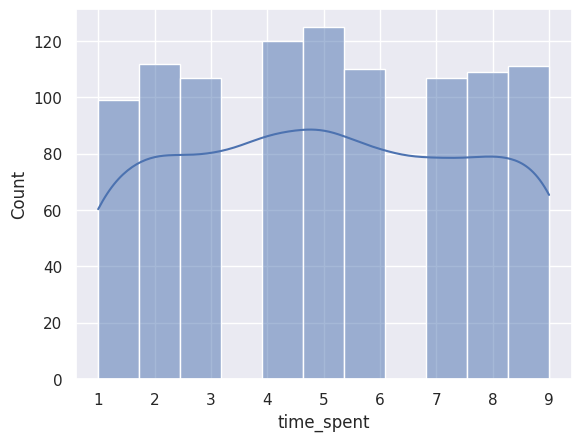

In [96]:
# histogram of time_spent
sns.histplot(df['time_spent'], kde=True)
plt.show()

In [97]:
def preprocess_df(df):
    # convert gender, interests, location, demographics, platform and profession to one hot encoding
    df_enc = pd.get_dummies(df, columns=['gender', 'interests', 'location', 'demographics', 'profession', 'platform'], drop_first=False)
    
    # normalize income and age
    df_enc['income'] = (df_enc['income'] - df_enc['income'].min()) / (df_enc['income'].max() - df_enc['income'].min())
    df_enc['age'] = (df_enc['age'] - df_enc['age'].min()) / (df_enc['age'].max() - df_enc['age'].min()) 
    return df_enc.drop('time_spent', axis=1), df_enc['time_spent']

In [98]:
X, y = preprocess_df(df)
X.head()

,age,income,indebt,isHomeOwner,Owns_Car,gender_female,gender_male,gender_non-binary,interests_Lifestlye,interests_Sports,...,location_United States,demographics_Rural,demographics_Sub_Urban,demographics_Urban,profession_Marketer Manager,profession_Software Engineer,profession_Student,platform_Facebook,platform_Instagram,platform_YouTube
0,0.826087,0.979334,True,False,False,False,True,False,False,True,...,False,False,False,True,False,True,False,False,True,False
1,0.608696,0.055377,True,True,True,True,False,False,False,False,...,False,False,False,True,False,False,True,True,False,False
2,0.304348,0.325642,False,False,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,True,False
3,0.913043,0.249599,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,True,False
4,0.152174,0.456862,False,True,True,False,True,False,True,False,...,False,False,False,True,False,True,False,False,True,False


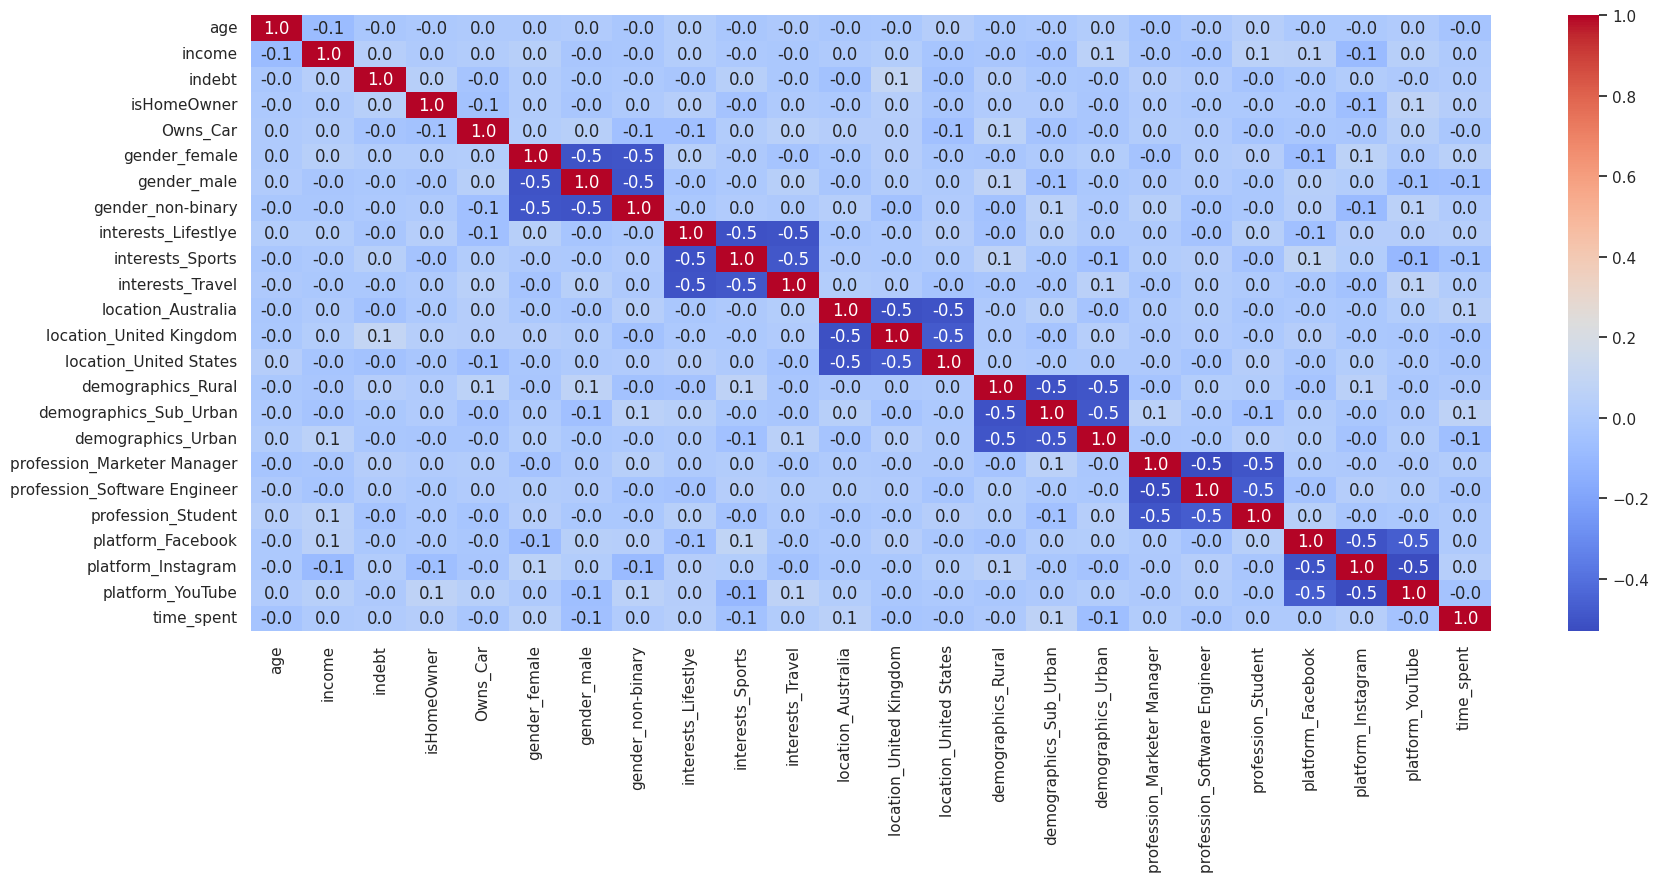

In [99]:
# correlation matrix, not very informative
corr = pd.concat((X,y), axis=1).corr()
plt.figure(figsize = (20,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()

In [100]:
# split the data into train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [101]:
X_train.shape, X_test.shape

((800, 23), (200, 23))

In [102]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta': [0.01, 0.1, 0.2],
        }

In [103]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, nthread=1)

In [104]:
skf_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10000, scoring='neg_root_mean_squared_error', n_jobs=4, 
                                   cv=skf_xgb.split(X_train, y_train), verbose=3, random_state=1001)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


/home/christian/Desktop/social-media-time-pred/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1215 is smaller than n_iter=10000. Running 1215 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=-2.497 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=-2.655 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=-2.676 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=-2.544 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=-2.609 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=-2.664 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, eta=0.01, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=-2.685 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, eta=0.

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x77f93c65f8b0>,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=...
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None,
                                          nthread=1, num_parallel_tree=None, ...),
                   n_iter=10000, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.01, 0.1, 0.2],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [105]:
random_search.best_score_

-2.54568401054049

In [106]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 5,
 'eta': 0.2,
 'colsample_bytree': 0.6}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

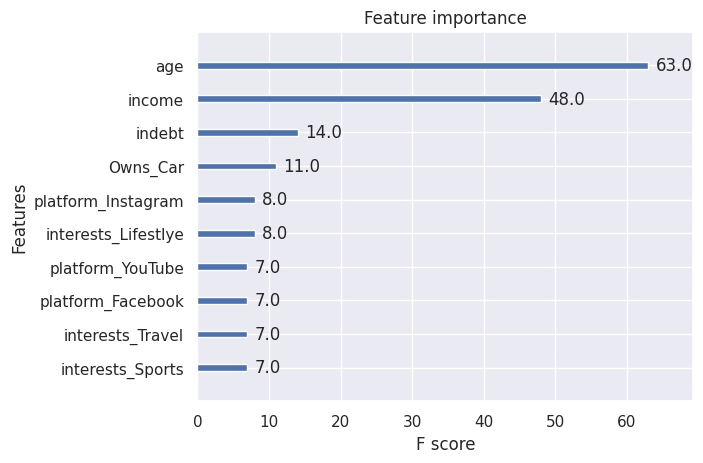

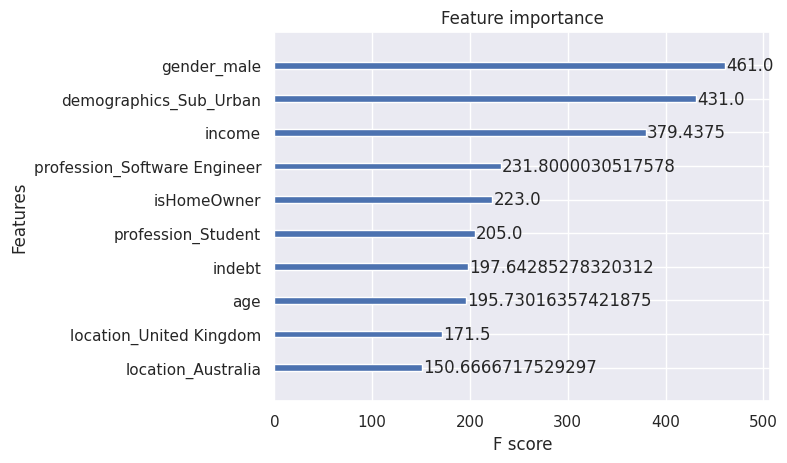

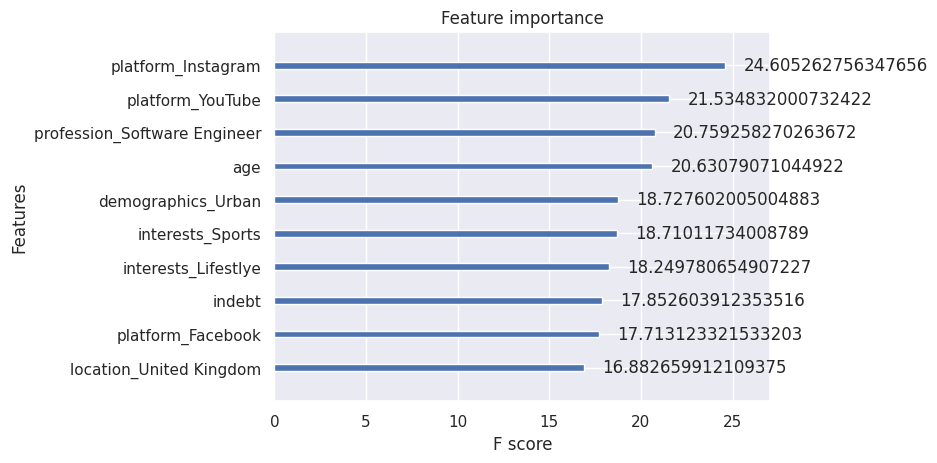

In [107]:
best_model = random_search.best_estimator_

#plot feature importance
xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
xgb.plot_importance(best_model, max_num_features=10, importance_type='cover')
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain')

In [108]:
# evaluate the model on the test data
from sklearn.metrics import mean_squared_error

y_pred = best_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2.614543359545727

At this point I tried out an approach with a simple Neural Network. The results were not as good as with the XGBoost model, so I will not include the code here. The model hopelessly overfitted the training data and the validation loss was not decreasing, even with dropout and L2/L1 regularization. The next step is to generate synthetic data and train the model on it to see if it can generalize better to unseen data.

In [109]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import os

The code for the DataSynthesizer is mostly from the repository example https://github.com/DataResponsibly/DataSynthesizer/blob/master/notebooks/DataSynthesizer__correlated_attribute_mode.ipynb

In [110]:
# read in input and transform all boolean columns to integers
df = pd.read_csv('dummy_data.csv')
df['indebt'] = df['indebt'].astype(int)
df['isHomeOwner'] = df['isHomeOwner'].astype(int)
df['Owns_Car'] = df['Owns_Car'].astype(int)

df.to_csv('dummy_data_processed.csv', index=False)

In [162]:
input_data = './dummy_data_processed.csv'
mode = 'correlated_attribute_mode'

# create the output directory and description file, because for some reason the library does not create it
os.makedirs(f'./out/{mode}', exist_ok=True)
f = open(f'./out/{mode}/description.json', "x")
f.close()

description_file = f'./out/{mode}/description.json'
synthetic_data = f'./out/{mode}/sythetic_data.csv'

FileExistsError: [Errno 17] File exists: './out/correlated_attribute_mode/description.json'

In [179]:
threshold_value = 5 # max number a category can have
degree_of_bayesian_network = 2
num_tuples_to_generate = 1000000

In [180]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=0.0, 
                                                        k=degree_of_bayesian_network)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT demographics
Adding attribute income
Adding attribute age
Adding attribute time_spent
Adding attribute location
Adding attribute interests
Adding attribute platform
Adding attribute profession
Adding attribute gender
Adding attribute Owns_Car
Adding attribute indebt
Adding attribute isHomeOwner
========================== BN constructed ==========================


In [181]:
display_bayesian_network(describer.bayesian_network)


Constructed Bayesian network:
    income      has parents ['demographics'].
    age         has parents ['income', 'demographics'].
    time_spent  has parents ['age', 'income'].
    location    has parents ['age', 'income'].
    interests   has parents ['age', 'income'].
    platform    has parents ['age', 'income'].
    profession  has parents ['age', 'income'].
    gender      has parents ['age', 'income'].
    Owns_Car    has parents ['age', 'income'].
    indebt      has parents ['age', 'income'].
    isHomeOwner has parents ['age', 'income'].


In [182]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [183]:
# Read both datasets using Pandas.
input_df = pd.read_csv(input_data, skipinitialspace=True)
synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

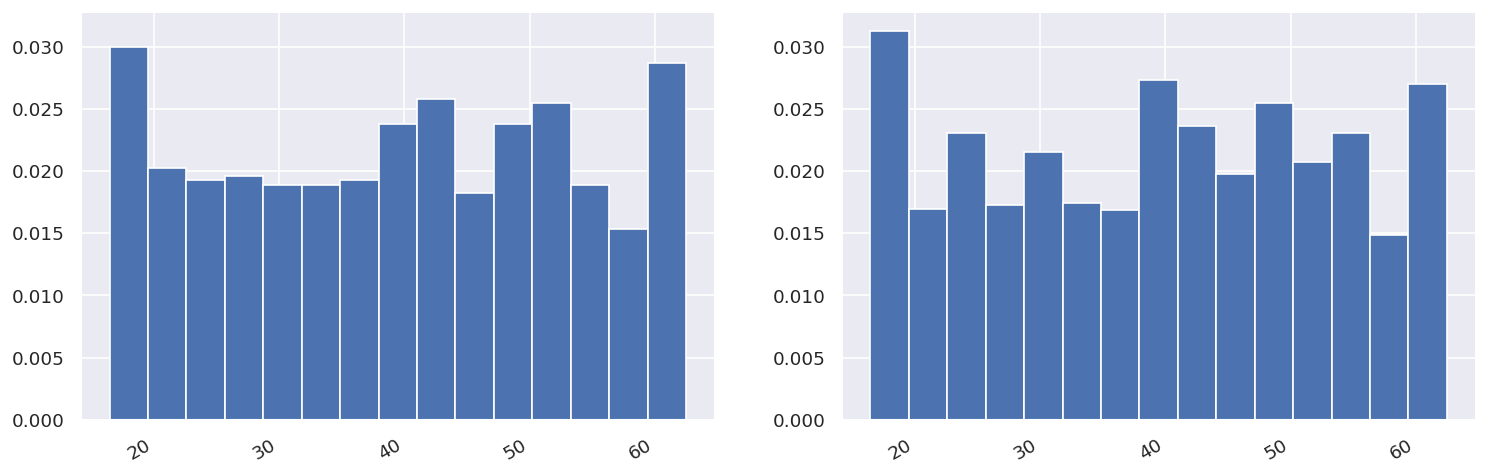

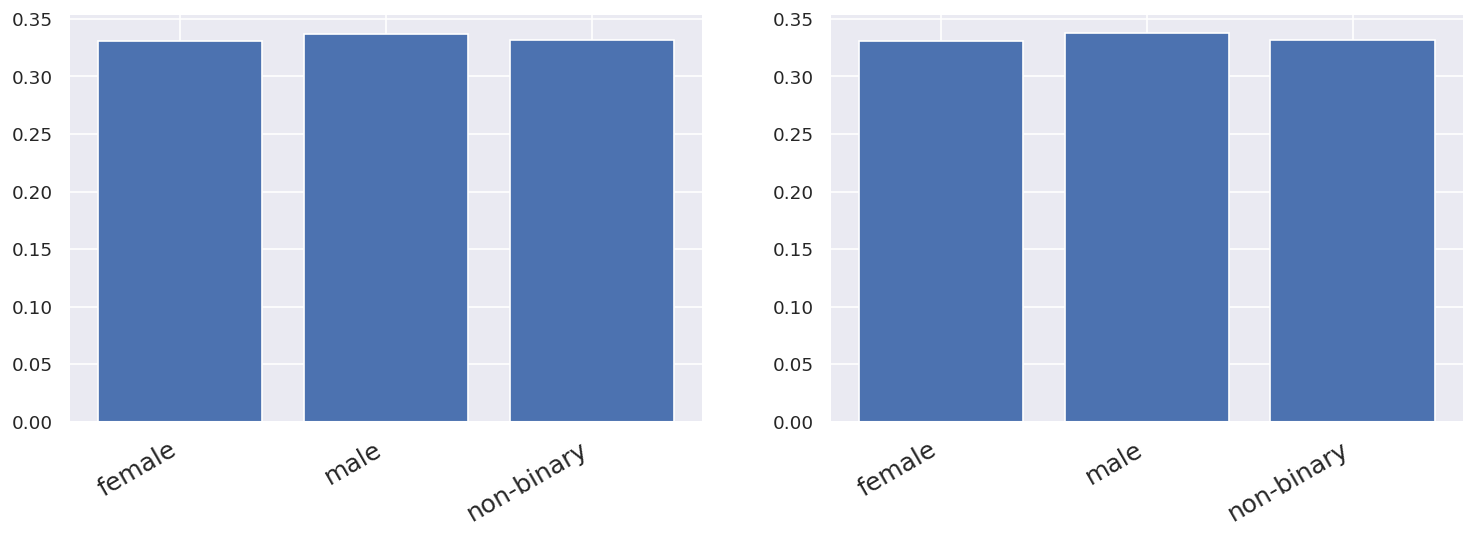

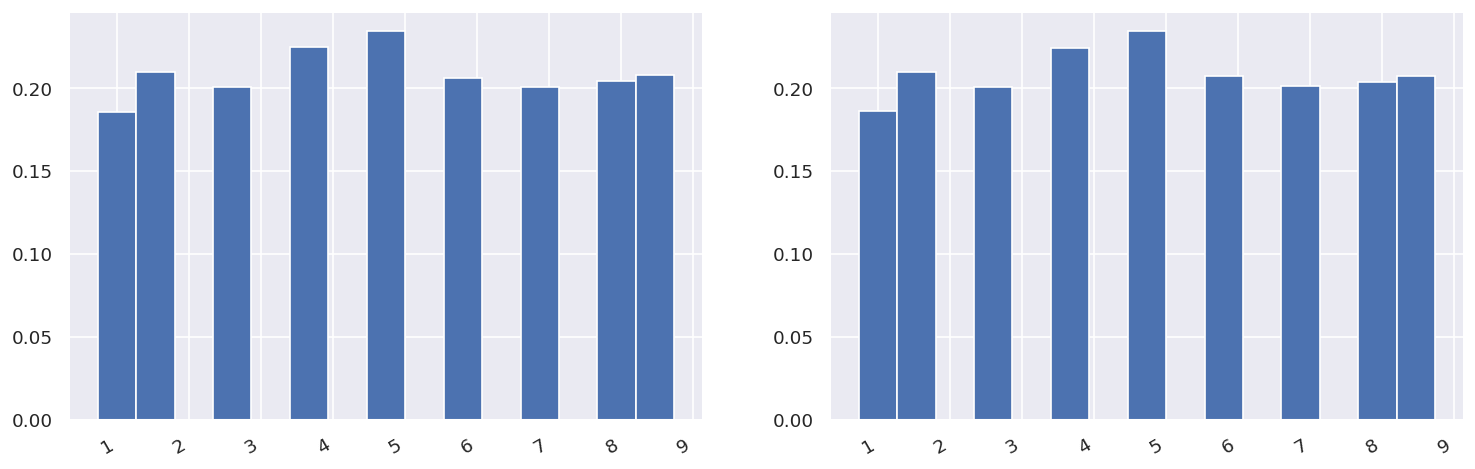

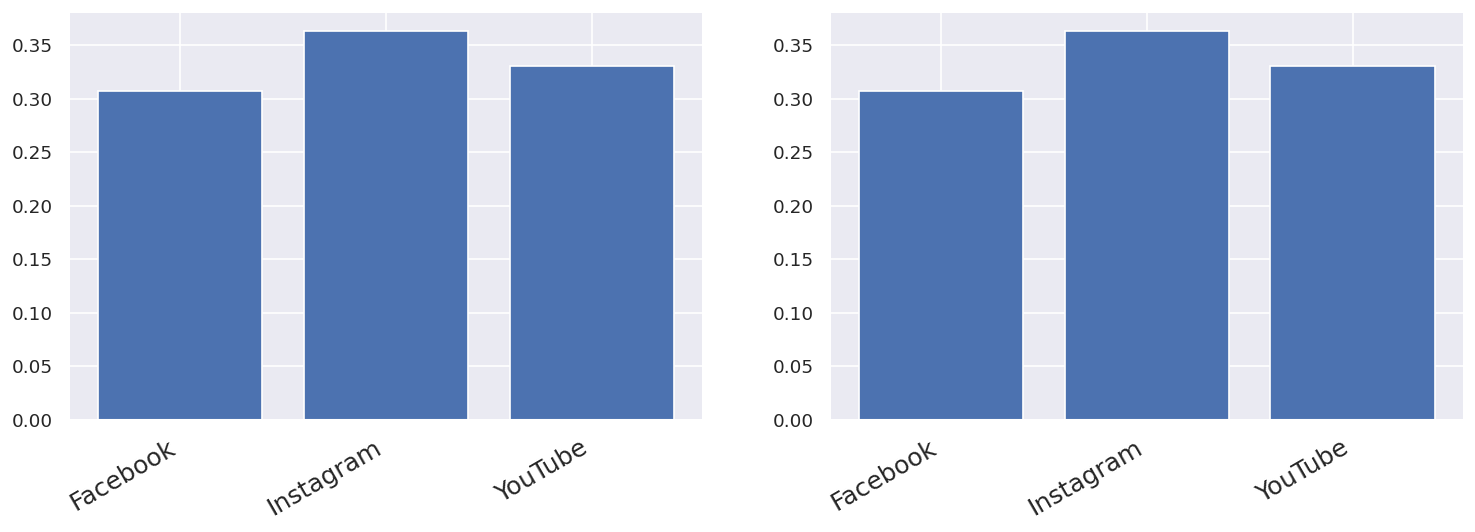

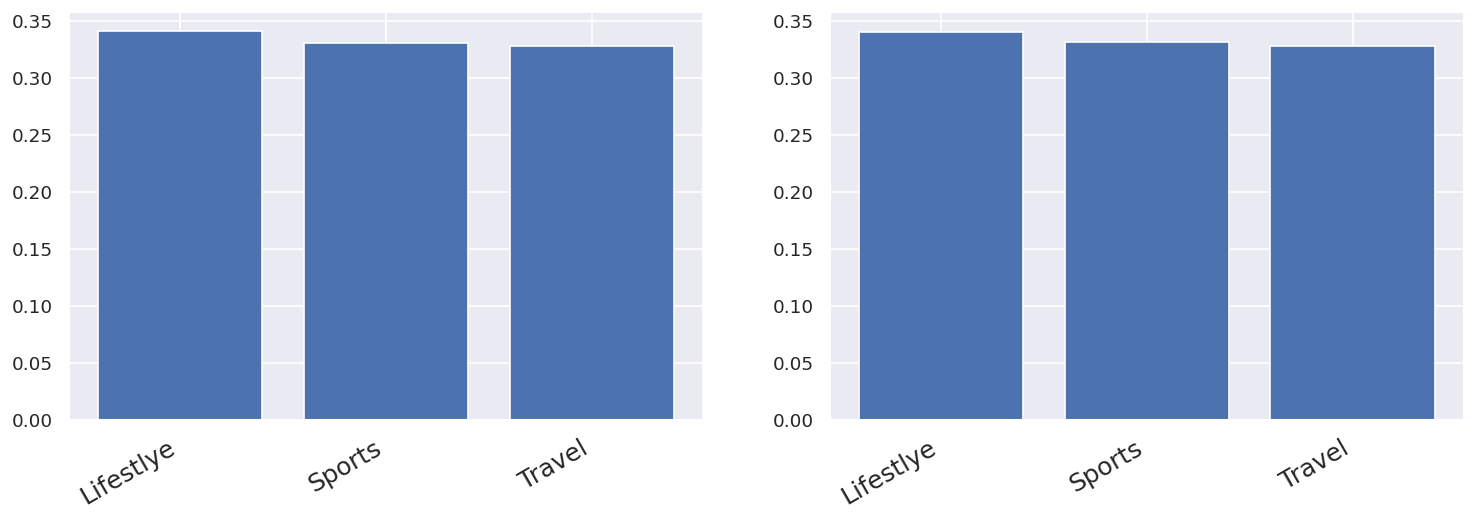

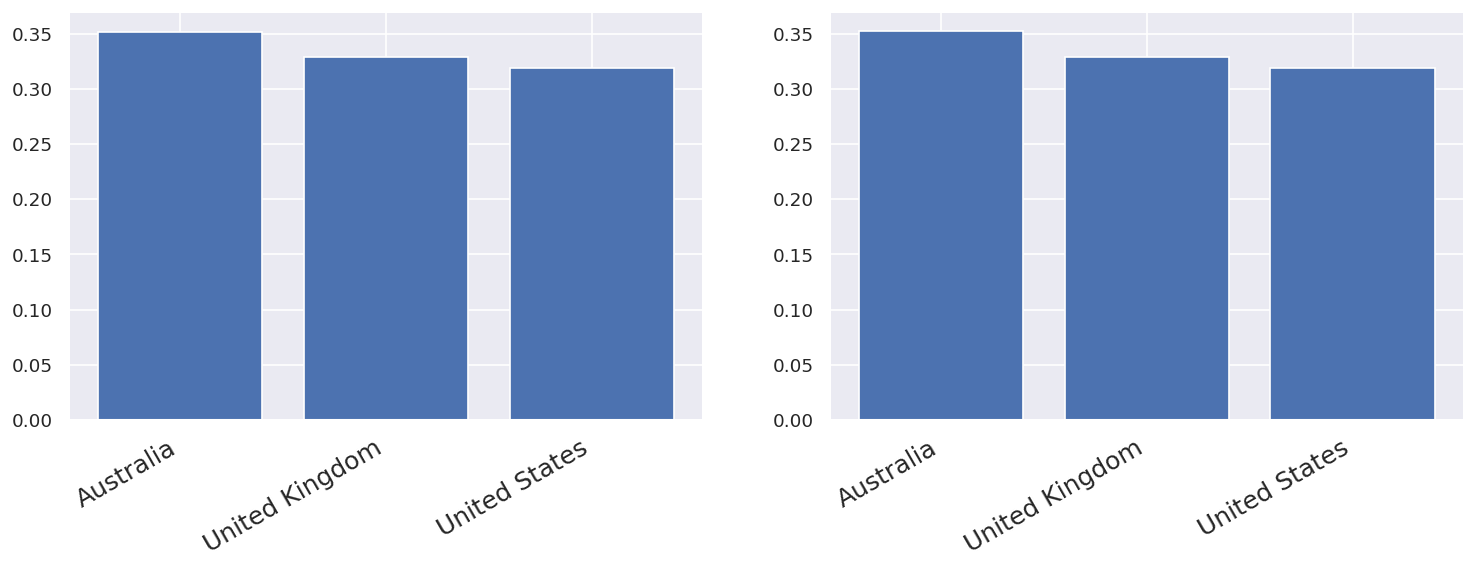

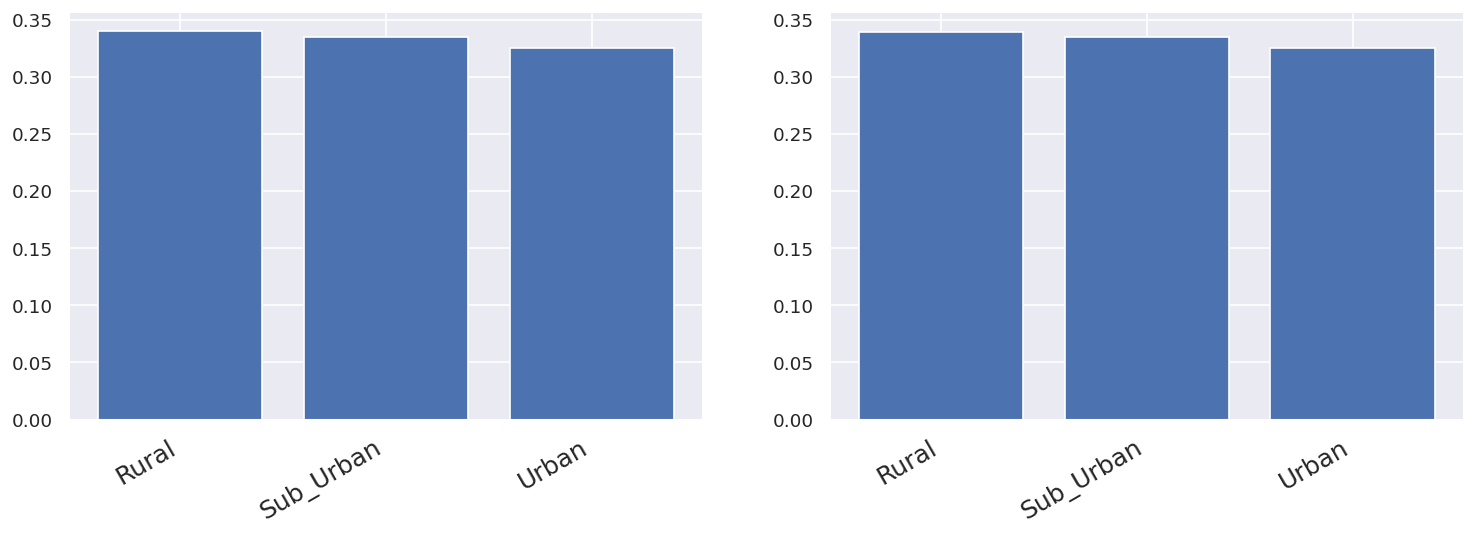

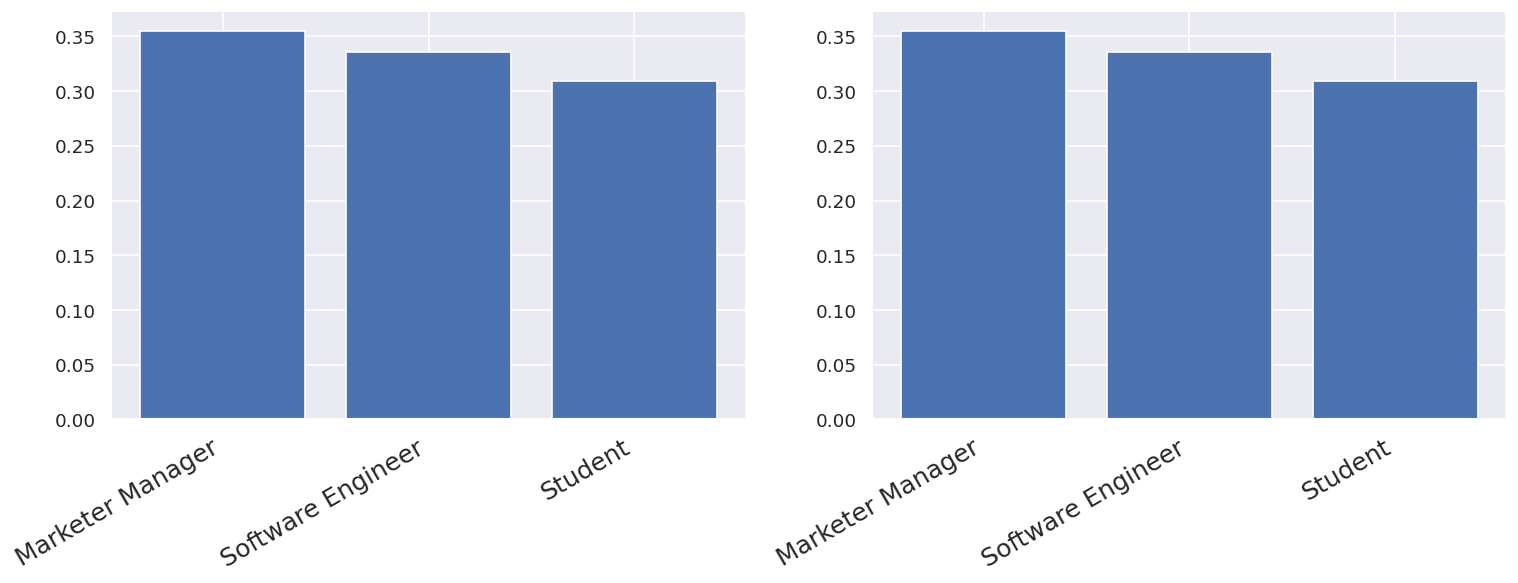

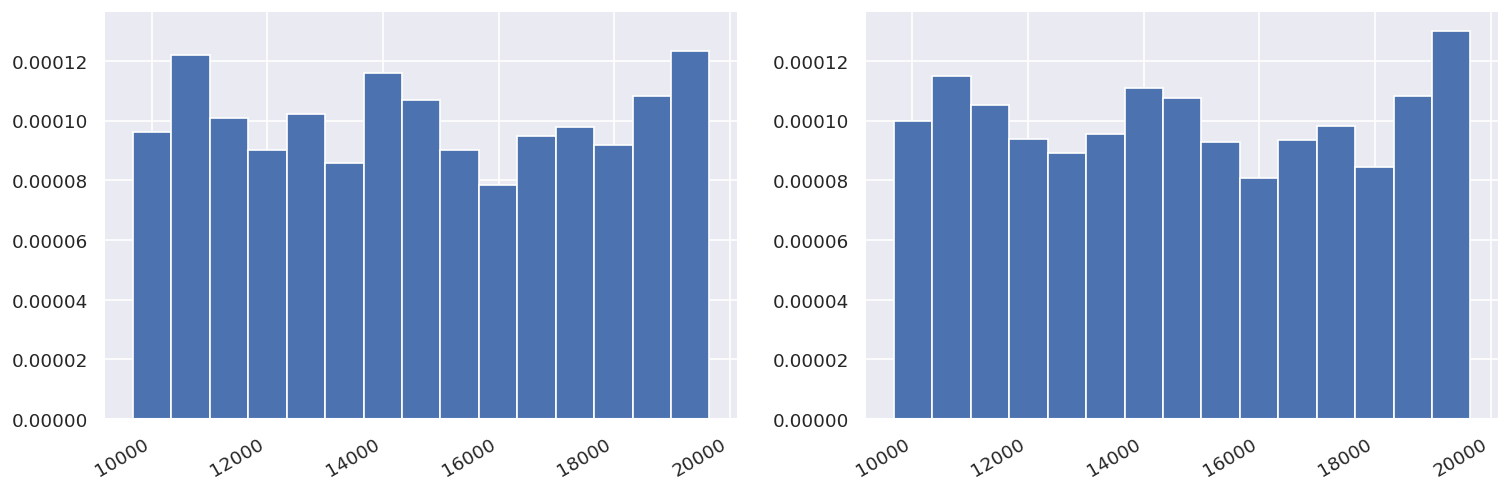

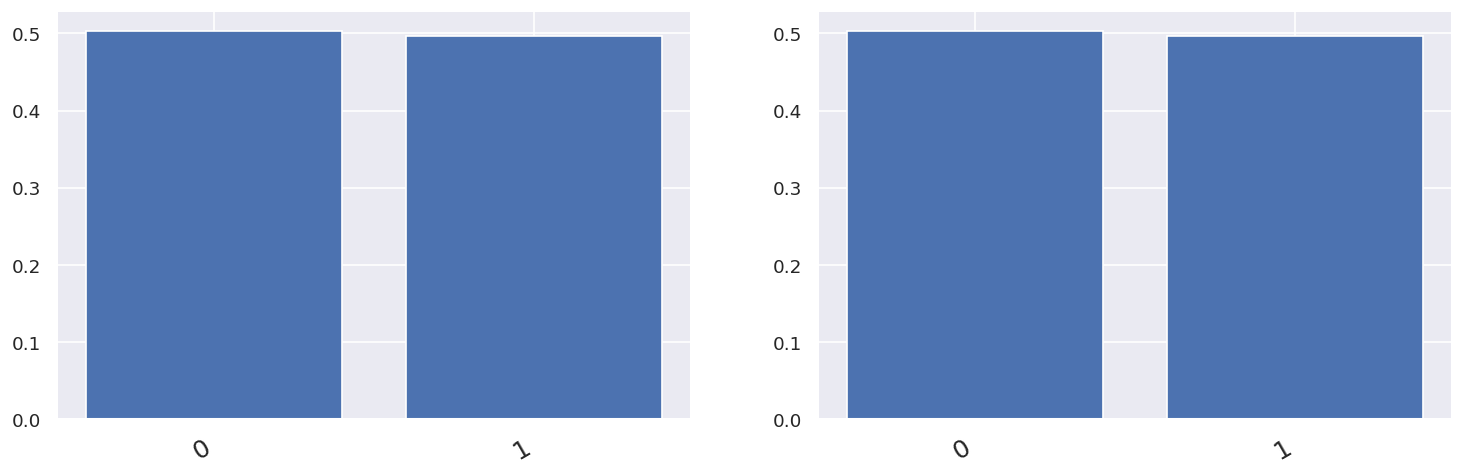

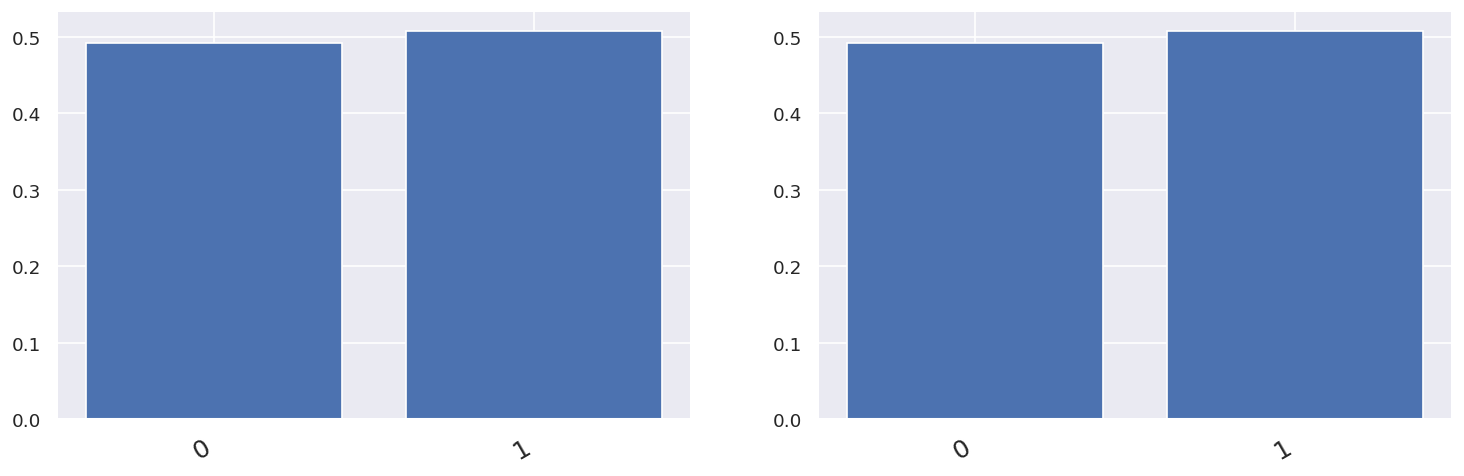

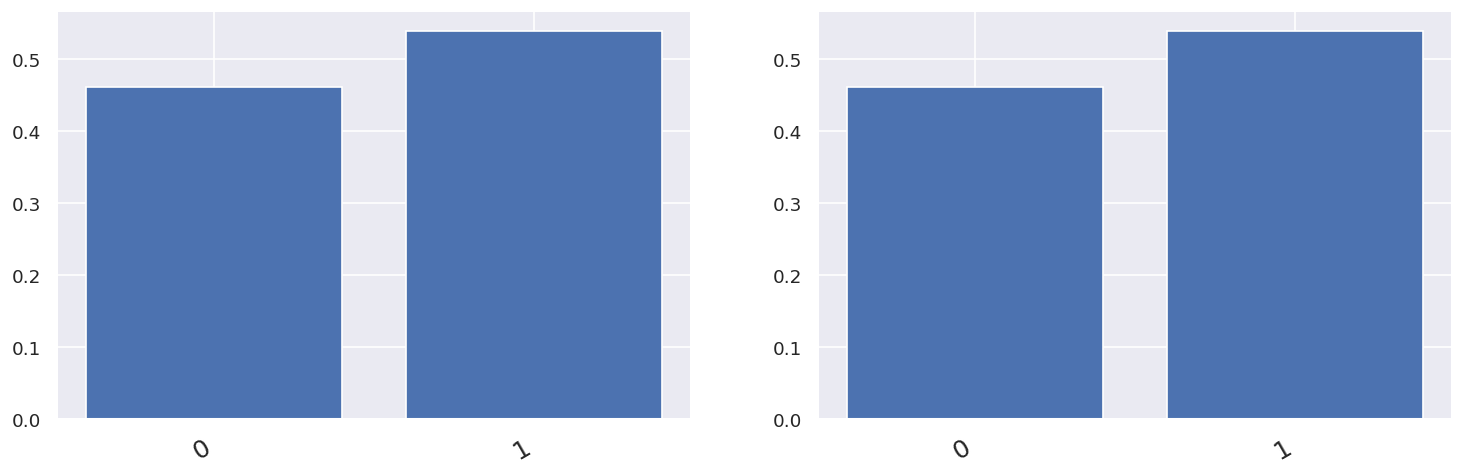

In [184]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

In [185]:
# preprocess the synthetic data
X_synthetic, y_synthetic = preprocess_df(synthetic_df)

# retrain the best estimator of our random search on the new synthetic data
best_model.fit(X_synthetic, y_synthetic)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, nthread=1, ...)

In [186]:
# evaluate the model on the test data
y_pred = best_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2.209993548765683